In [5]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import random
import cv2

from google.cloud import storage

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import datasets

from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras_tuner
from kerastuner.tuners import RandomSearch

from numpy import savez_compressed
from numpy import load

from datetime import datetime

import sklearn
from sklearn.model_selection import train_test_split
import scikitplot as skplt
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay as cmd

import time

import warnings
warnings.filterwarnings('ignore')

## Config

Configuration of important paths.

In [6]:
raw_path = 'data/raw'
split_path = 'data/split'

## Load model & Test data

In [7]:
model = tf.keras.models.load_model('models/my_vgg16.h5')

In [8]:
test_gen = ImageDataGenerator(
    rescale=1./255 
)

In [9]:
classes = os.listdir(split_path + '/test')
if '.DS_Store' in classes:
        classes.remove('.DS_Store')

test_size = 0

for c in classes:
    test_size += len(os.listdir(split_path + '/test/' + c)) - 1

In [10]:
test_data = test_gen.flow_from_directory(
    directory = split_path + '/test', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=test_size, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)

X_test,y_true = test_data.next()
y_true = y_true.astype(int)
y_labels = list(test_data.class_indices.keys())

Found 183 images belonging to 3 classes.


# Evaluate model's performance

## Create predictions

In [16]:
pred_proba = model.predict(X_test)
pred_binary = np.argmax(pred_proba, axis=1)

## Accuracy, Confusion Matrix, Classification Report

In [ ]:
cm = multilabel_confusion_matrix(y_true, pred_binary)

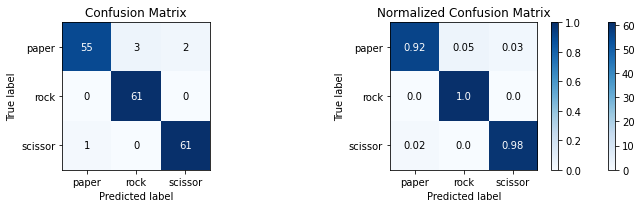

In [118]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

skplt.metrics.plot_confusion_matrix(y_true, pred_binary, normalize=False, ax = ax1)
skplt.metrics.plot_confusion_matrix(y_true, pred_binary, normalize='pred', ax = ax2)

plt.setp((ax1, ax2), 
         xticks=list(range(0, len(y_labels))), xticklabels=y_labels, 
         yticks=list(range(0, len(y_labels))), yticklabels=y_labels )

fig.tight_layout()

plt.show()

In [187]:
print(skm.classification_report(y_true = y_true, 
                                y_pred = pred_binary, 
                                labels = list(range(0, len(y_labels))),
                                target_names = y_labels))

              precision    recall  f1-score   support

       paper       0.98      0.92      0.95        60
        rock       0.95      1.00      0.98        61
     scissor       0.97      0.98      0.98        62

    accuracy                           0.97       183
   macro avg       0.97      0.97      0.97       183
weighted avg       0.97      0.97      0.97       183



## Inspect curves

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

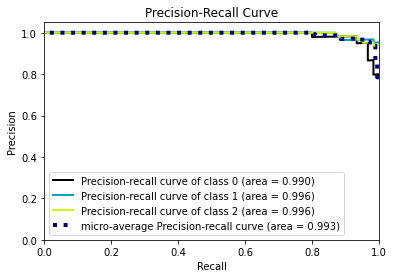

In [97]:
skplt.metrics.plot_precision_recall_curve(y_true, pred_proba)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

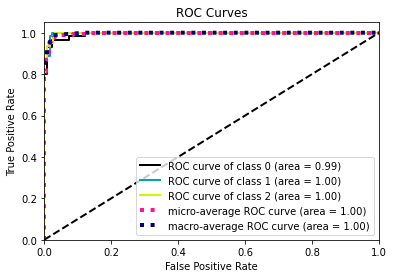

In [106]:
skplt.metrics.plot_roc_curve(y_true, pred_proba)

## Inspect individual predictions

In [7]:
def plot_prediction_proba(i, predictions, true_label, model_input, class_names):
    true_label, img, pred = true_label[i], model_input[i], predictions[i]

    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    cell_text = []

    for r in range(len(predictions[i])):
        cell_text.append([class_names[r],'{:2.2f}%'.format(round(predictions[i][r]*100,2))])
        cell_text = sorted(cell_text,key=lambda l:l[1], reverse = True)

    cell_text.append(['True class', class_names[true_label]])
    
    plt.table(cellText = cell_text, loc = 'bottom')
    
    if np.argmax(pred) == true_label:
        label_color = 'green'
        title = 'True'
    else:
        label_color = 'red'
        title = 'False'
    plt.title(title, color = label_color)



In [9]:
plt.figure(figsize=(30,7.5))

rnd_imgs = np.random.randint(0, len(pred_proba)-1, 20)
sp = 1

for i in rnd_imgs:
    plt.subplot(2,10,sp)
    sp += 1
    plot_prediction_proba(i ,pred_proba, y_true, X_test, y_labels)
    plt.subplots_adjust(hspace = .4)

plt.show()

NameError: name 'pred_proba' is not defined

<Figure size 2160x540 with 0 Axes>

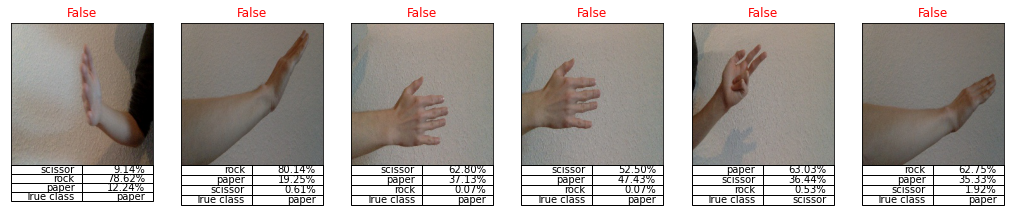

In [113]:
states = y_true!=pred_binary
pred_false = np.where(states)[0]

plt.figure(figsize=(30,7.5))

i = 1
for p in pred_false:
    plt.subplot(2,10,i)
    i += 1
    plot_prediction_proba(p ,pred_proba, y_true, X_test, y_labels)
    plt.subplots_adjust(hspace = .4)

plt.show()


## Inspect individual predictions based on images done with webcam

In [ ]:
def test_webcam_img (true_label):
    
    cam = cv2.VideoCapture(0)
    time.sleep(0.1)
    ret, frame = cam.read()

    if not ret:
        print('failed to grab frame')
        return

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cam.release()
    
    test_img = cv2.resize(frame, (224, 224)) 

    test_img = test_img.reshape([1,224,224,3])
    pred = model.predict(test_img)
    plot_prediction_proba(0 ,pred, [y_labels.index(true_label)], test_img, y_labels)

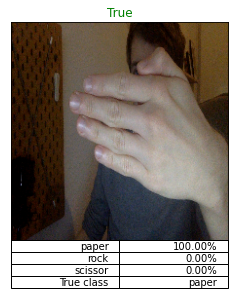

In [30]:
test_webcam_img('paper')

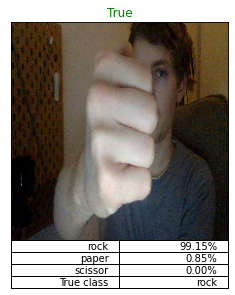

In [42]:
test_webcam_img('rock')

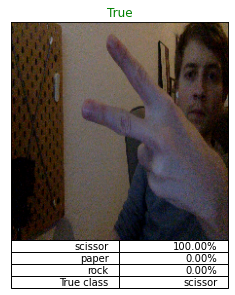

In [13]:
test_webcam_img('scissor')

# Understand the model (IML Methods)

In [ ]:
#print model structure

## Explaining features learned by printing weights of model layers

Layer: block1_conv1
Filter size: 64
whatever: 3


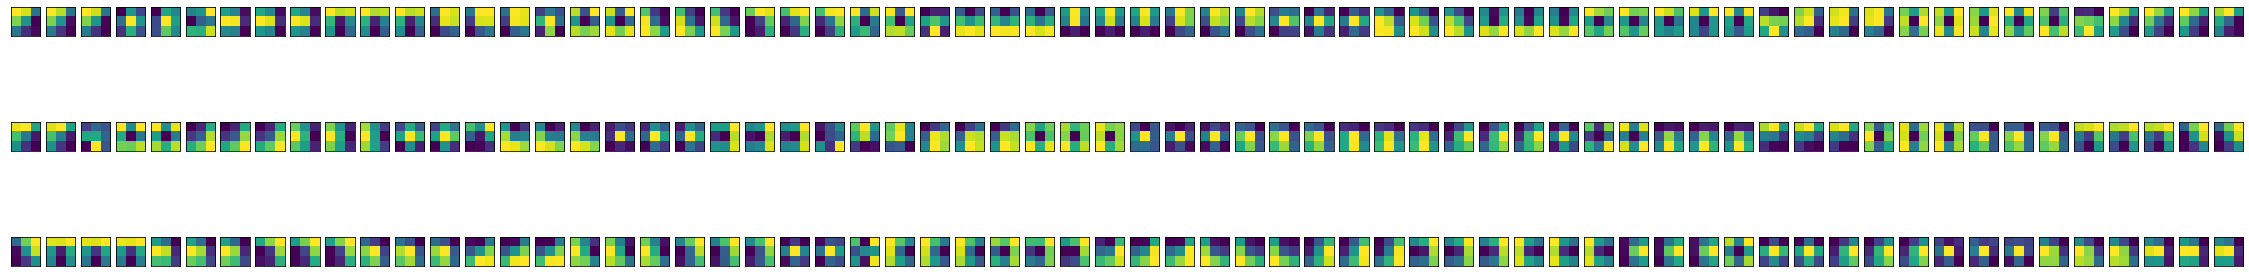

Layer: block1_conv2
Filter size: 64
whatever: 3


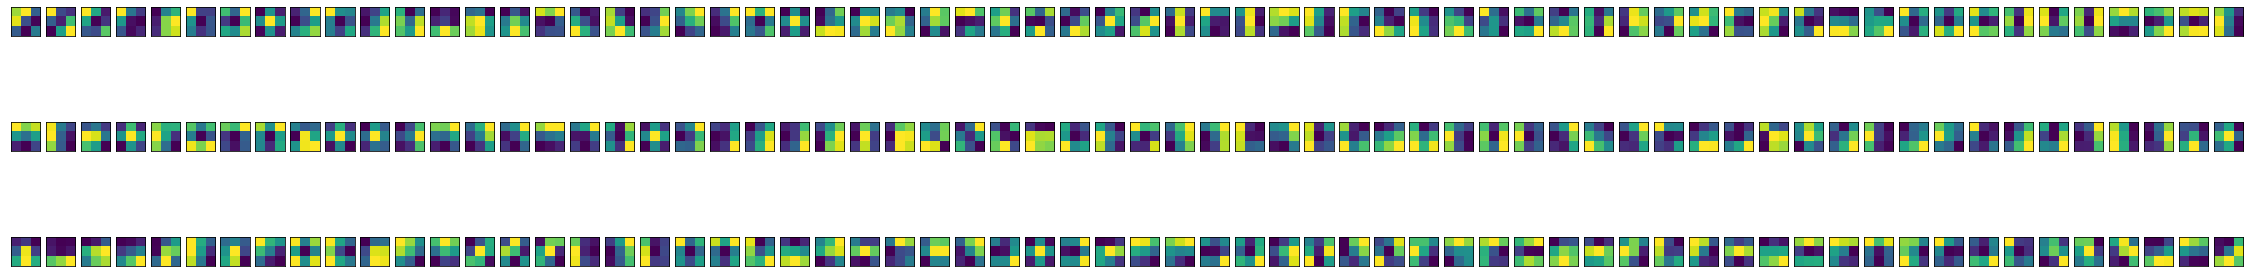

Layer: block2_conv1
Filter size: 128
whatever: 3


In [7]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print('Layer: ' + str(layer.name))
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print('Filter size: ' + str(filters.shape[3]))
        print('whatever: ' + str(filters.shape[0]))
        filter_cnt=1
        
        plt.figure(figsize=(40,round(number = filters.shape[0]*2)))
        #plotting all the filters
        for i in range(filters.shape[3]):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting each of the channel, color image RGB channels
            for j in range(round(filters.shape[0])):
                ax= plt.subplot(filters.shape[0], filters.shape[3], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

## Explaining features learned by printing feature maps for individual images

In [ ]:
#https://towardsdatascience.com/convolutional-neural-network-feature-map-and-filter-visualization-f75012a5a49c

In [37]:
def display_feature_maps(img, max_num_layers):

  successive_outputs = [layer.output for layer in model.layers[1:]]

  visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

  x = img.reshape((1,224,224,3))

  successive_feature_maps = visualization_model.predict(x)
  # Retrieve are the names of the layers, so can have them as part of our plot
  layer_names = [layer.name for layer in model.layers]

  num_layers = 1
  for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if max_num_layers != 'all':
      if num_layers > max_num_layers:
        return
    if len(feature_map.shape) == 4 and 'conv' in layer_name: # make shure to only analyse not fully-connected layers
      num_layers += 1
      n_features = feature_map.shape[-1]  # number of features in the feature map
      size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
      
      display_grid = np.zeros((size, size * n_features))
      
      # Postprocess the feature to be visually palatable
      for i in range(n_features):
        x  = feature_map[0, :, :, i]
        x -= x.mean()
        x /= x.std ()
        x *=  64
        x += 128
        x  = np.clip(x, 0, 255).astype('uint8')
        # Tile each feature map into a horizontal grid
        display_grid[:, i * size : (i + 1) * size] = x
  # Display the feature maps per layer
      scale = 40. / n_features
      plt.figure( figsize=(scale * n_features, scale) )
      plt.title ( layer_name + ' - no of filters: ' + str(n_features))
      plt.grid  ( False )
      plt.xticks([])
      plt.yticks([])
      plt.imshow( display_grid, aspect='auto', cmap='viridis' )

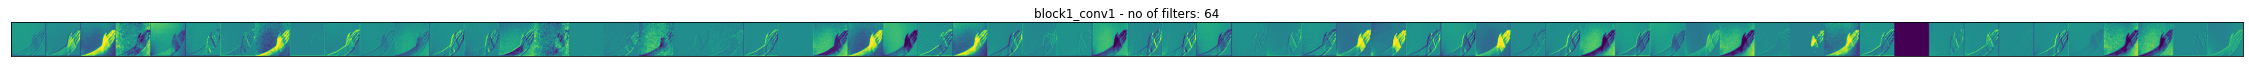

In [40]:
display_feature_maps(X_test[0], 1)

## Explaining individual predictions with SHAP

In [ ]:
#Hint: run on tensorflow 2.3 -> works!
#https://github.com/karndeepsingh/Explainable-Ai/blob/main/Explaining_Deep_Learning_Models_Using_Shap_Values.ipynb

In [ ]:
import shap

In [9]:
classes_dict = dict()
for i, l in enumerate(y_true):
  if len(classes_dict)==(len(y_labels)):
    break
  if l not in classes_dict.keys():
    classes_dict[l] = X_test[i].reshape((224, 224,3))

In [22]:
def plot_shap_header(categories):
  fig, axes = plt.subplots(1, len(categories)+1, figsize=(len(categories)*2 + 1, len(categories)*2))
  axes = axes.flatten()
  
  # Plot an empty tile
  ax = axes[0]
  dummy_tile = np.array([[[0, 0, 0, 0]]], dtype='uint8')
  ax.set_title("reference")
  ax.set_axis_off()
  ax.imshow(dummy_tile, interpolation='nearest')

  # Plot an image for every category
  for k,v in categories.items():
    ax = axes[k+1]
    ax.imshow(v, cmap=plt.cm.binary)
    ax.set_title(f"{y_labels[k]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

In [ ]:
classes = os.listdir(split_path + '/train')
if '.DS_Store' in classes:
        classes.remove('.DS_Store')

train_size = 0

for c in classes:
    train_size += len(os.listdir(split_path + '/train/' + c)) - 1

train_gen = ImageDataGenerator(
    rescale=1./255 #,rotation_range=40, width_shift_range=0.2,height_shift_range=0.2, shear_range=0.2, zoom_range=0.2
    #brightness_range, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, preprocessing_function=None
)

train_data = train_gen.flow_from_directory(
    directory = split_path + '/train', 
    target_size=(224, 224), 
    color_mode='rgb', 
    class_mode='sparse', 
    batch_size=train_size, 
    shuffle=True, 
    seed=1,
    interpolation='nearest'
)
X_train,y_train = train_data.next()

In [5]:
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
e = shap.DeepExplainer(model, background)

In [85]:
state_false = y_true!=pred_binary
pred_false = np.where(state_false)[0]

state_true = y_true==pred_binary
pred_true = np.where(state_true)[0]

x_Test_one_true_per_class = []
x_Test_one_false_per_class = []

for i in range(len(y_labels)):
    x_Test_one_true_per_class.append(np.zeros([224,224,3]))
    x_Test_one_false_per_class.append(np.zeros([224,224,3]))

    for c in pred_true:
        if y_true[c] == i:
            x_Test_one_true_per_class[i] = X_test[c]
    for c in pred_false:
        if y_true[c] == i:
            x_Test_one_false_per_class[i] = X_test[c]   

In [6]:
shap_values_trues = e.shap_values(x_Test_one_true_per_class, check_additivity=False)

In [ ]:
plot_shap_header(classes_dict)
print() # blank to seperate plots
shap.image_plot(shap_values_trues, -x_Test_one_true_per_class)

In [ ]:
shap_values_falses = e.shap_values(x_Test_one_false_per_class, check_additivity=False)

In [ ]:
plot_shap_header(classes_dict)
print() # blank to seperate plots
shap.image_plot(shap_values_trues, -x_Test_one_false_per_class)

## Explaining individual predictions with LIME

In [8]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [9]:
explainer = lime_image.LimeImageExplainer(random_state=1)

In [33]:
def lime_explain(index, X_array, y_array):
     i = index

     explanation = explainer.explain_instance(
          X_array[i].astype('double'), 
          model.predict
     )

     pred = model.predict(X_array[i].reshape((1,224,224,3)))

     plt.imshow(X_array[i])
     image, mask = explanation.get_image_and_mask(
          pred.argmax(axis=1)[0],
          positive_only=False, 
          hide_rest=False)
     plt.imshow(mark_boundaries(image, mask, color=(0.2, 0.2, 0)))
     
     plt.grid(False)
     plt.xticks([])
     plt.yticks([])

     cell_text = []

     for r in range(len(pred[0])):
          cell_text.append([y_labels[r],'{:2.2f}%'.format(round(pred[0][r]*100,2))])
          cell_text = sorted(cell_text,key=lambda l:l[1], reverse = True)

     cell_text.append(['True class', y_labels[y_array[i]]])
     
     plt.table(cellText = cell_text, loc = 'bottom')
     
     if np.argmax(pred) == y_array[i]:
          label_color = 'green'
          title = 'True'
     else:
          label_color = 'red'
          title = 'False'
     plt.title(title, color = label_color)

100%|██████████| 1000/1000 [05:41<00:00,  2.93it/s]


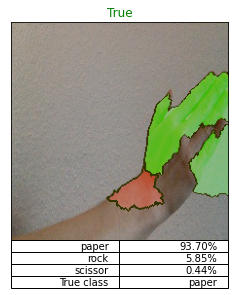

In [34]:
lime_explain(0, X_test, y_true)